In [131]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib
import polars as pl
import os, json

from lib.weather_api import query_weather

In [132]:
PATH = os.getcwd()
time_format = '%Y-%m-%dT%H:%M:%S'

In [153]:
matplotlib.rcParams.update({'font.size': 14, 'font.family':'sans serif', 'font.weight':'normal'})

In [134]:
def print_df(df: pl.DataFrame, sort_by: str, n:int):
    with pl.Config() as cfg:
        cfg.set_tbl_cols(-1)
        cfg.set_tbl_width_chars(1000)
        cfg.set_tbl_rows(-1)
        print(df.sort(by=sort_by, descending=True).head(n))

In [135]:
# date range of simulation
forecast_range = 7
from_date = datetime(year=2023, month=6, day=1, hour=0, minute=0, second=0)
to_date = from_date + timedelta(days=forecast_range)

In [136]:
# load data frames
topology = 'S_1412610_T_1412615'
topology_df = pl.read_parquet(os.path.join(PATH,"../../data/silver/",topology)).sort(by='fromTime', descending=False)
valuta_df = pl.read_parquet(os.path.join(PATH,"../../data/raw/price/",'euro_2_nok_valuta_2023-03-01_2023-09-02')).sort(by='timestamp', descending=False)
spot_df = pl.read_parquet(os.path.join(PATH,"../../data/raw/price/",'historic_2023-03-01_2023-09-02')).sort(by='Timestamp', descending=False)

In [137]:
# determine the area for price code
features_df = pl.read_parquet(os.path.join(PATH,"../../data/bronze/features/production"))
price_area = features_df.filter(pl.col('topology')==topology).select(pl.col('price_area').first()).item()

In [138]:
# determine the latitude and longitude
latitude = features_df.filter(pl.col('topology')==topology).select(pl.col('latitude').first()).item()
longitude = features_df.filter(pl.col('topology')==topology).select(pl.col('longitude').first()).item()
print(f"Latitude:{latitude} Longitude:{longitude}")

Latitude:59.7266804377451 Longitude:10.8655261797295


In [139]:
# get data, valuta and spot for date range
weather_df = query_weather(latitude=latitude, longitude=longitude, date_from=datetime.now(), forecast_range=forecast_range)
topology_df = (topology_df.filter(pl.col('fromTime').is_between(from_date, to_date)))
valuta_df = (valuta_df.filter(pl.col('timestamp').is_between(from_date, to_date)))
spot_df = (spot_df.filter(pl.col('Timestamp').is_between(from_date, to_date)))

In [140]:
# calculator to convert area Euro/MWh to NOK/kWh
def exhange_calculator(exchange: pl.DataFrame, price: pl.DataFrame):
    return (price.with_columns(pl.col('Timestamp')
                               .cast(pl.Datetime())).rename({'Timestamp':'timestamp'})
            .join(exchange, on='timestamp', validate='1:1')
            .with_columns((pl.col('NO1')*pl.col('nok_euro')/1000).alias('NO1'),
                          (pl.col('NO2')*pl.col('nok_euro')/1000).alias('NO2'),
                          (pl.col('NO3')*pl.col('nok_euro')/1000).alias('NO3'),
                          (pl.col('NO4')*pl.col('nok_euro')/1000).alias('NO4'),
                          (pl.col('NO5')*pl.col('nok_euro')/1000).alias('NO5')
                          ).select(['timestamp','NO1','NO2','NO3','NO4','NO5']))

In [141]:
price_df = exhange_calculator(exchange=valuta_df, price=spot_df)

In [142]:
# limit
prod_limit_kwh = 70
load_limit_kwh = 70

# plot aggregated neighborhood over week
ami_cnt = topology_df.n_unique(subset='meteringPointId')

# calculate aggregated and average of columns
df = (topology_df.sort(by=['fromTime']).group_by_dynamic('fromTime', every='1h').agg(
    pl.col('p_load_kwh').sum().alias('p_load_sum_kwh'),
    (pl.col('p_load_kwh').sum()/ami_cnt).alias('p_load_avg_kwh'),
    pl.col('p_prod_kwh').sum().alias('p_prod_sum_kwh'),
    (pl.col('p_prod_kwh').sum()/ami_cnt).alias('p_prod_avg_kwh'),
    (pl.col('p_prod_kwh')-pl.col('p_load_kwh')).sum().alias('p_export_sum_kwh'),
    ((pl.col('p_prod_kwh')-pl.col('p_load_kwh')).sum()/ami_cnt).alias('p_export_avg_kwh')
).with_columns(load_limit=pl.lit(load_limit_kwh), prod_limit=pl.lit(prod_limit_kwh))).with_columns(
    pl.when(pl.col('load_limit')<pl.col('p_load_sum_kwh'))
    .then(pl.lit(load_limit_kwh))
    .otherwise(pl.col('p_load_sum_kwh'))
    .alias('req_load_kwh'),
    pl.when(pl.col('prod_limit')<pl.col('p_prod_sum_kwh'))
    .then(pl.lit(prod_limit_kwh))
    .otherwise(pl.col('p_prod_sum_kwh'))
    .alias('req_prod_kwh')
).with_columns(pl.when(pl.col('req_load_kwh')>pl.col('p_load_sum_kwh'))
               .then(pl.lit(0))
               .otherwise(pl.col('p_load_sum_kwh')-pl.col('req_load_kwh')).alias('shave_load_by_kwh'),
               pl.when(pl.col('req_prod_kwh')>pl.col('p_prod_sum_kwh'))
               .then(pl.lit(0))
               .otherwise(pl.col('p_prod_sum_kwh')-pl.col('req_prod_kwh')).alias('shave_prod_by_kwh')
               )

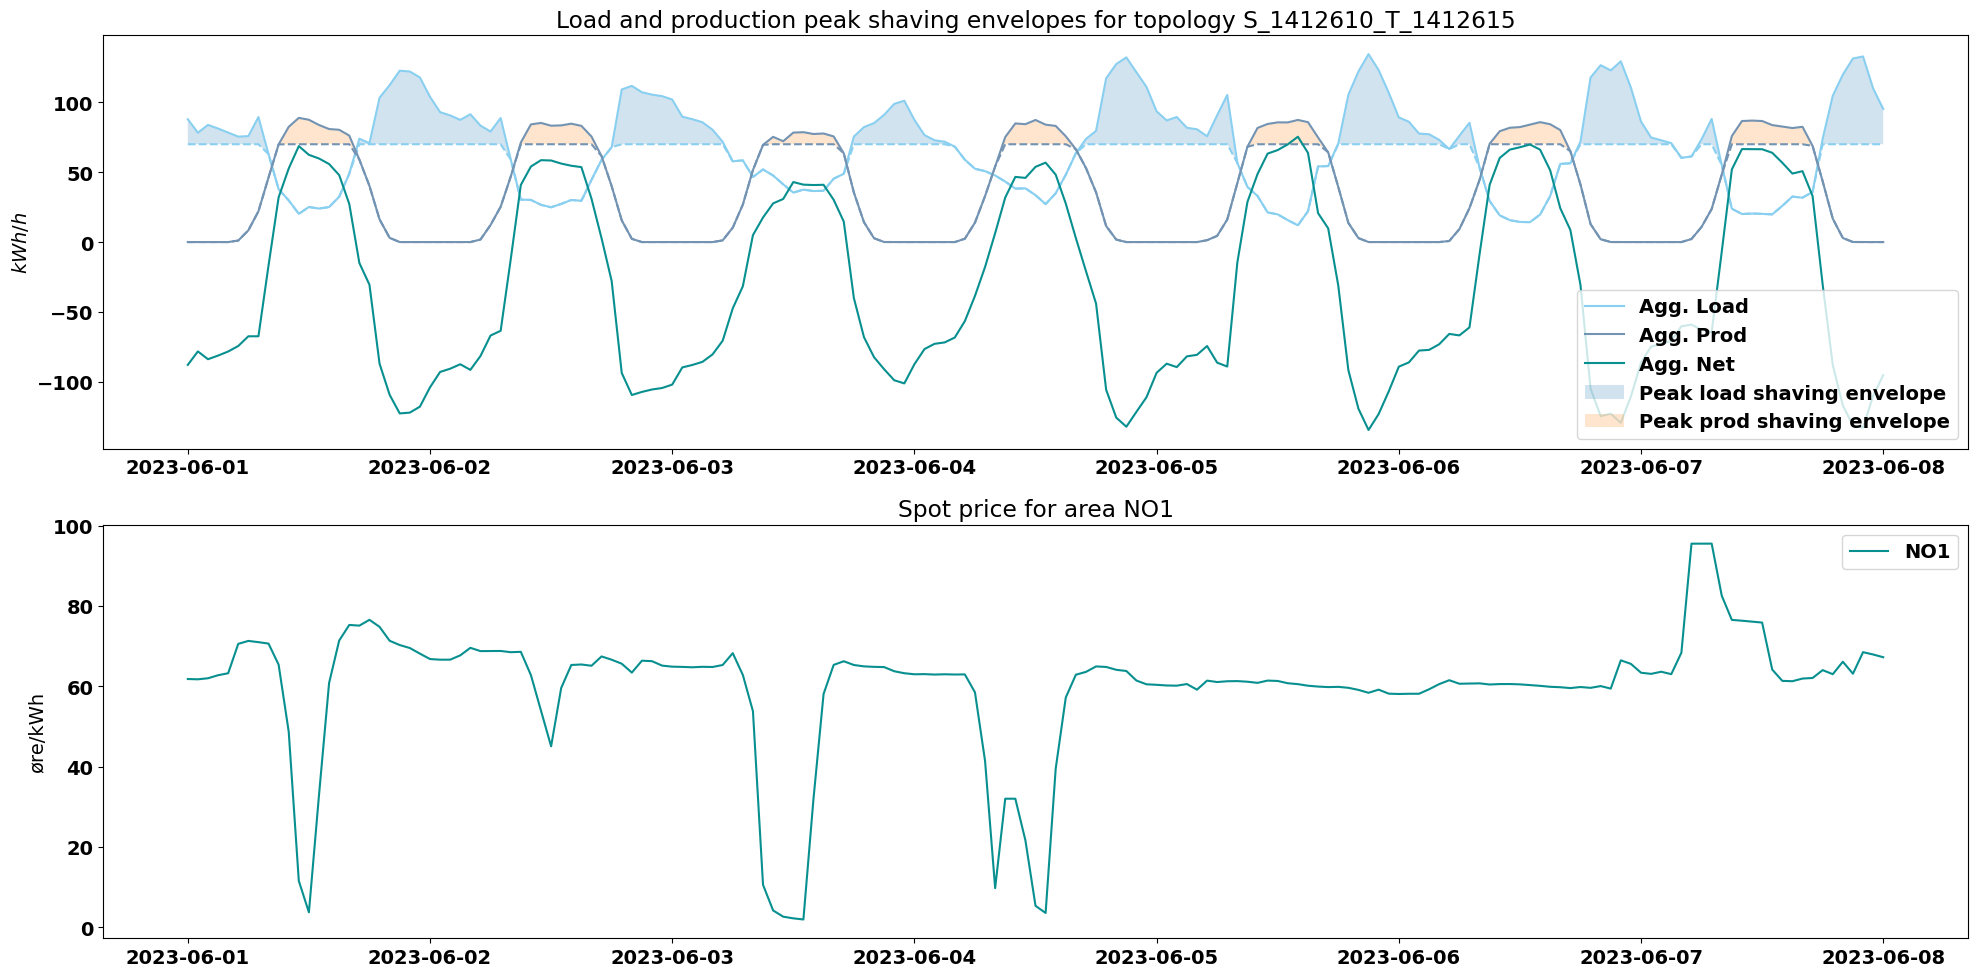

In [143]:
fig, ax = plt.subplots(2,1, figsize=(20,10))

ax[0].plot(df['fromTime'], df['p_load_sum_kwh'], color='#89CFF0', label='Agg. Load')
ax[0].plot(df['fromTime'], df['req_load_kwh'], color='#89CFF0', linestyle='dashed')
ax[0].plot(df['fromTime'], df['p_prod_sum_kwh'], color='#7393B3', label='Agg. Prod')
ax[0].plot(df['fromTime'], df['req_prod_kwh'], color='#7393B3', linestyle='dashed')
ax[0].plot(df['fromTime'], df['p_export_sum_kwh'], color='#088F8F', label='Agg. Net')

ax[0].fill_between(df['fromTime'], df['p_load_sum_kwh'], df['req_load_kwh'], alpha=0.2, label='Peak load shaving envelope')
ax[0].fill_between(df['fromTime'], df['p_prod_sum_kwh'], df['req_prod_kwh'], alpha=0.2, label='Peak prod shaving envelope')
ax[0].set_ylabel('$kWh/h$')
ax[0].set_title(f'Load and production peak shaving envelopes for topology {topology}')
ax[0].legend()

ax[1].plot(price_df['timestamp'], price_df[price_area]*100, color='#088F8F', label=f'{price_area}')
ax[1].set_ylabel('øre/kWh')
ax[1].set_title(f'Spot price for area {price_area}')
ax[1].legend()

fig.tight_layout()

In [144]:
df_envelope=df.select(['fromTime', 'shave_load_by_kwh','shave_prod_by_kwh'])
df_envelope = (df_envelope.with_columns(pl.col('fromTime').dt.strftime(time_format).alias('from_time'),
                                       (pl.col('fromTime')+timedelta(hours=1)).dt.strftime(time_format).alias('to_time')))\
    .select(['from_time','to_time','shave_load_by_kwh','shave_prod_by_kwh']).sort(by='from_time', descending=False)

In [145]:
with open('../data/spark_asset_event_v2.json','w+') as fp:
    json.dump([row for row in df_envelope.iter_rows(named=True)],fp)

In [146]:
weather_df = weather_df\
    .with_columns(pl.col('timestamp').alias('from_time'),
                  (pl.col('timestamp')+timedelta(hours=1)).alias('to_time'),
                  ((100-pl.col('cloudcover'))*pl.col('solarradiation')).alias('production_potential')
                  )\
    .with_columns(pl.when(pl.col('production_potential')>0)
                  .then(pl.lit('1'))
                  .otherwise(pl.lit('0'))
                  .alias('solar_surplus')
                  ) \
    .select(['from_time','to_time','humidity', 'cloudcover', 'solarradiation','solar_surplus']).sort(by='from_time', descending=False)

print(weather_df)

shape: (192, 6)
┌──────────────┬─────────────────────┬──────────┬────────────┬────────────────┬───────────────┐
│ from_time    ┆ to_time             ┆ humidity ┆ cloudcover ┆ solarradiation ┆ solar_surplus │
│ ---          ┆ ---                 ┆ ---      ┆ ---        ┆ ---            ┆ ---           │
│ datetime[μs] ┆ datetime[μs]        ┆ f64      ┆ f64        ┆ f64            ┆ str           │
╞══════════════╪═════════════════════╪══════════╪════════════╪════════════════╪═══════════════╡
│ 2023-12-07   ┆ 2023-12-07 01:00:00 ┆ 88.65    ┆ 94.5       ┆ 0.0            ┆ 0             │
│ 00:00:00     ┆                     ┆          ┆            ┆                ┆               │
│ 2023-12-07   ┆ 2023-12-07 02:00:00 ┆ 86.75    ┆ 88.0       ┆ 0.0            ┆ 0             │
│ 01:00:00     ┆                     ┆          ┆            ┆                ┆               │
│ 2023-12-07   ┆ 2023-12-07 03:00:00 ┆ 86.75    ┆ 88.0       ┆ 0.0            ┆ 0             │
│ 02:00:00     ┆        

ColumnNotFoundError: timestamp

Error originated just after this operation:
DF ["from_time", "to_time", "humidity", "cloudcover"]; PROJECT */6 COLUMNS; SELECTION: "None"

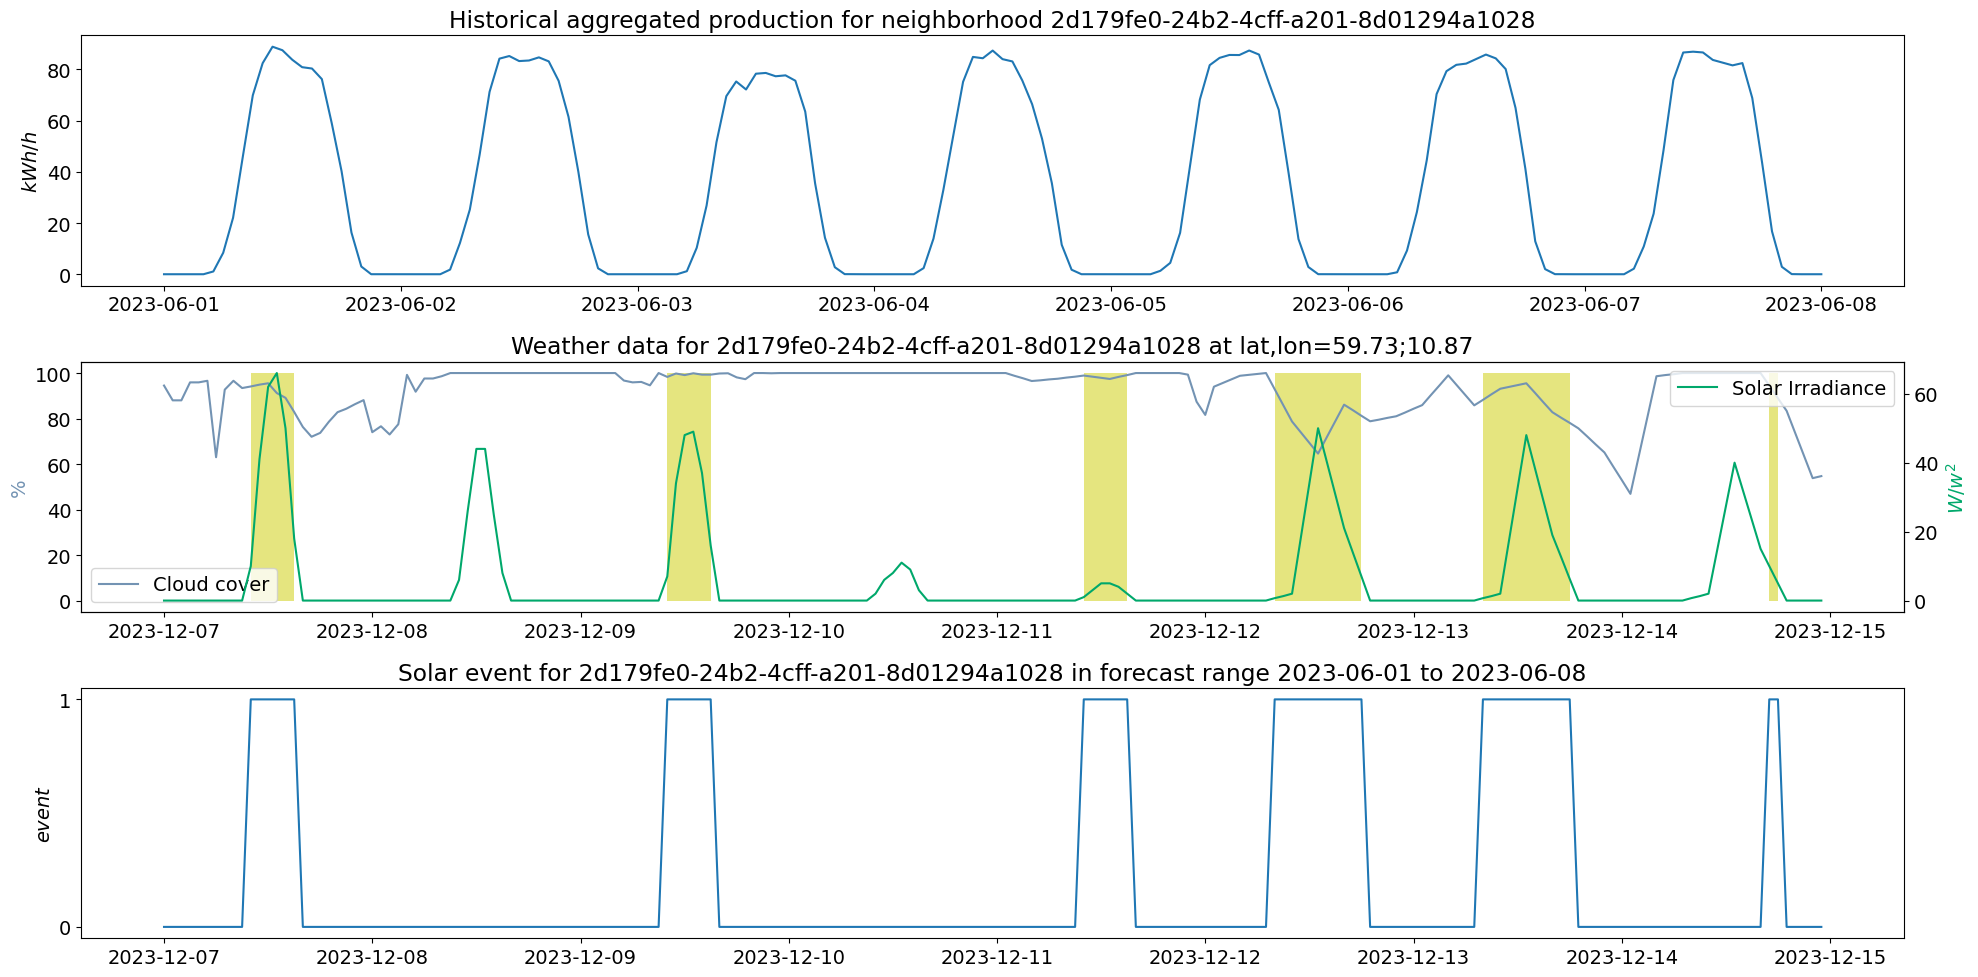

In [156]:
neighborhood_id = '2d179fe0-24b2-4cff-a201-8d01294a1028'
fig, ax = plt.subplots(3,1, figsize=(20,10))

ax[0].plot(df['fromTime'], df['p_prod_sum_kwh'], label='Agg. Load')
ax[0].set_ylabel('$kWh/h$')
ax[0].set_title(f'Historical aggregated production for neighborhood {neighborhood_id}')

ax[1].plot(weather_df['from_time'], weather_df['cloudcover'],label='Cloud cover',color='#7393B3')
ax[1].set_ylabel('%',color='#7393B3')
ax[1].legend()
ax[1].set_title(f'Weather data for {neighborhood_id} at lat,lon={round(latitude,2)};{round(longitude,2)}')
ax[1].fill_between(weather_df['from_time'], 100, where=weather_df['solar_surplus']>0, facecolor='#cccc00', alpha=.5)

ax1_dual = ax[1].twinx()
ax1_dual.plot(weather_df['from_time'], weather_df['solarradiation'], label='Solar Irradiance',color='#00A86B')
ax1_dual.set_ylabel('$W/w^2$',color='#00A86B')
ax1_dual.legend()

ax[2].plot(weather_df['from_time'], weather_df['solar_surplus'], label='Incentive')
ax[2].set_ylabel('$event$')
ax[2].set_title(f'Solar event for {neighborhood_id} in forecast range {from_date.date()} to {(from_date+timedelta(days=forecast_range)).date()}')

fig.tight_layout()
plt.savefig('../figures/forecaster2asset_event_v1.png')

In [149]:
df_event_version1 = weather_df.with_columns((pl.col('from_time')+timedelta(hours=1)).dt.strftime(time_format).alias('to_time'),\
                                              pl.col('from_time').dt.strftime(time_format).alias('from_time'))\
    .select(['from_time','to_time','humidity', 'cloudcover', 'solarradiation', 'solar_surplus']).sort(by='from_time', descending=False)

In [ ]:
with open('../data/spark_asset_event_v1.json','w+') as fp:
    data = [row for row in df_event_version1.iter_rows(named=True)]
    event = {'neighborhood_id':neighborhood_id, 'timeseries':data}
    json.dump(event,fp)